In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.special import comb
from scipy.stats import normaltest
from numba import njit, prange

In [2]:
class Urn:

    def __init__(self, K_arr):
        """
        Initialization given the number of each type i object in the urn.

        Parameters
        ----------
        K_arr: ndarray(int)
            number of each type i object.
        """

        self.K_arr = np.array(K_arr)
        self.N = np.sum(K_arr)
        self.c = len(K_arr)

    def pmf(self, k_arr):
        """
        Probability mass function.

        Parameters
        ----------
        k_arr: ndarray(int)
            number of observed successes of each object.
        """

        K_arr, N = self.K_arr, self.N

        k_arr = np.atleast_2d(k_arr)
        n = np.sum(k_arr, 1)

        num = np.prod(comb(K_arr, k_arr), 1)
        denom = comb(N, n)

        pr = num / denom

        return pr

    def moments(self, n):
        """
        Compute the mean and variance-covariance matrix for
        multivariate hypergeometric distribution.

        Parameters
        ----------
        n: int
            number of draws.
        """

        K_arr, N, c = self.K_arr, self.N, self.c

        # mean
        μ = n * K_arr / N

        # variance-covariance matrix
        Σ = np.full((c, c), n * (N - n) / (N - 1) / N ** 2)
        for i in range(c-1):
            Σ[i, i] *= K_arr[i] * (N - K_arr[i])
            for j in range(i+1, c):
                Σ[i, j] *= - K_arr[i] * K_arr[j]
                Σ[j, i] = Σ[i, j]

        Σ[-1, -1] *= K_arr[-1] * (N - K_arr[-1])

        return μ, Σ

    def simulate(self, n, size=1, seed=None):
        """
        Simulate a sample from multivariate hypergeometric
        distribution where at each draw we take n objects
        from the urn without replacement.

        Parameters
        ----------
        n: int
            number of objects for each draw.
        size: int(optional)
            sample size.
        seed: int(optional)
            random seed.
        """

        K_arr = self.K_arr

        gen = np.random.Generator(np.random.PCG64(seed))
        sample = gen.multivariate_hypergeometric(K_arr, n, size=size)

        return sample

In [3]:
# construct the urn
K_arr = [5, 10, 15]
urn = Urn(K_arr)

In [4]:
k_arr = [2, 2, 2] # array of number of observed successes
urn.pmf(k_arr)

array([0.0795756])

In [5]:
k_arr = [[2, 2, 2], [1, 3, 2]]
urn.pmf(k_arr)

array([0.0795756, 0.1061008])

In [6]:
n = 6
μ, Σ = urn.moments(n)

In [7]:
μ

array([1., 2., 3.])

In [8]:
Σ

array([[ 0.68965517, -0.27586207, -0.4137931 ],
       [-0.27586207,  1.10344828, -0.82758621],
       [-0.4137931 , -0.82758621,  1.24137931]])

In [9]:
K_arr = [157, 11, 46, 24]
urn = Urn(K_arr)

In [10]:
k_arr = [10, 1, 4, 0]
urn.pmf(k_arr)

array([0.01547738])

In [11]:
k_arr = [[5, 5, 4 ,1], [10, 1, 2, 2], [13, 0, 2, 0]]
urn.pmf(k_arr)

array([6.21412534e-06, 2.70935969e-02, 1.61839976e-02])

In [12]:
n = 6 # number of draws
μ, Σ = urn.moments(n)

In [13]:
# mean
μ

array([3.95798319, 0.27731092, 1.15966387, 0.60504202])

In [14]:
# variance-covariance matrix
Σ

array([[ 1.31862604, -0.17907267, -0.74884935, -0.39070401],
       [-0.17907267,  0.25891399, -0.05246715, -0.02737417],
       [-0.74884935, -0.05246715,  0.91579029, -0.11447379],
       [-0.39070401, -0.02737417, -0.11447379,  0.53255196]])

In [15]:
size = 10_000_000
sample = urn.simulate(n, size=size)

In [16]:
# mean
np.mean(sample, 0)

array([3.9580205, 0.2772215, 1.159751 , 0.605007 ])

In [17]:
# variance covariance matrix
np.cov(sample.T)

array([[ 1.31808515, -0.1793423 , -0.74849341, -0.39024945],
       [-0.1793423 ,  0.25884597, -0.05224462, -0.02725905],
       [-0.74849341, -0.05224462,  0.91521031, -0.11447228],
       [-0.39024945, -0.02725905, -0.11447228,  0.53198078]])

In [18]:
sample_normal = np.random.multivariate_normal(μ, Σ, size=size)

In [19]:
def bivariate_normal(x, y, μ, Σ, i, j):

    μ_x, μ_y = μ[i], μ[j]
    σ_x, σ_y = np.sqrt(Σ[i, i]), np.sqrt(Σ[j, j])
    σ_xy = Σ[i, j]

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)

    return np.exp(-z / (2 * (1 - ρ**2))) / denom

In [20]:
@njit
def count(vec1, vec2, n):
    size = sample.shape[0]

    count_mat = np.zeros((n+1, n+1))
    for i in prange(size):
        count_mat[vec1[i], vec2[i]] += 1

    return count_mat

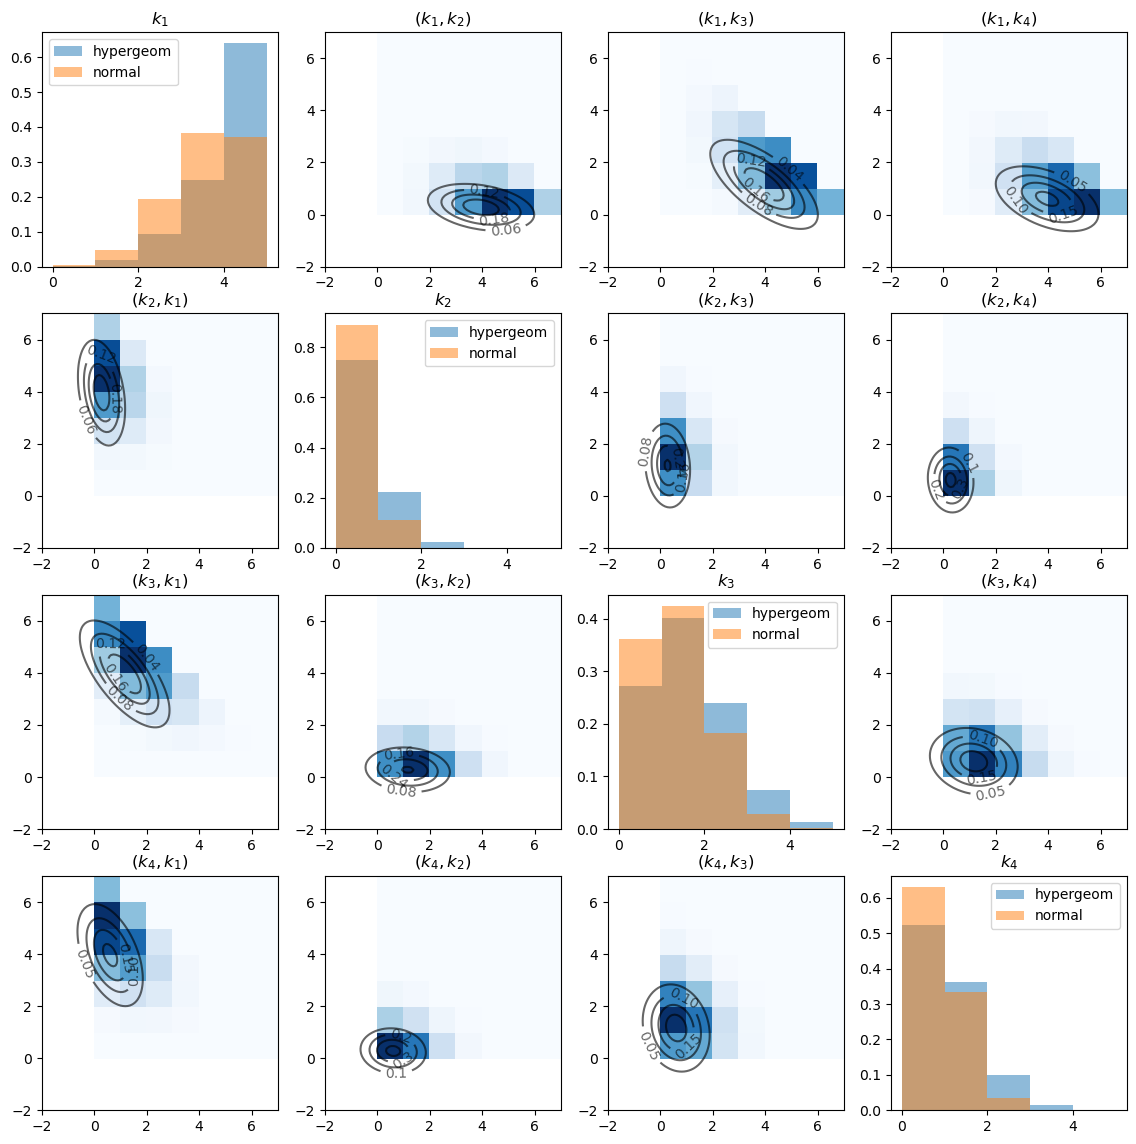

In [21]:
c = urn.c
fig, axs = plt.subplots(c, c, figsize=(14, 14))

# grids for ploting the bivariate Gaussian
x_grid = np.linspace(-2, n+1, 100)
y_grid = np.linspace(-2, n+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

for i in range(c):
    axs[i, i].hist(sample[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='hypergeom')
    axs[i, i].hist(sample_normal[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='normal')
    axs[i, i].legend()
    axs[i, i].set_title('$k_{' +str(i+1) +'}$')
    for j in range(c):
        if i == j:
            continue

        # bivariate Gaussian density function
        Z = bivariate_normal(X, Y, μ, Σ, i, j)
        cs = axs[i, j].contour(X, Y, Z, 4, colors="black", alpha=0.6)
        axs[i, j].clabel(cs, inline=1, fontsize=10)

        # empirical multivariate hypergeometric distrbution
        count_mat = count(sample[:, i], sample[:, j], n)
        axs[i, j].pcolor(count_mat.T/size, cmap='Blues')
        axs[i, j].set_title('$(k_{' +str(i+1) +'}, k_{' + str(j+1) + '})$')

plt.show()

In [22]:
test_multihyper = normaltest(sample)
test_multihyper.pvalue

array([0., 0., 0., 0.])

In [23]:
test_normal = normaltest(sample_normal)
test_normal.pvalue

array([0.64066326, 0.04198527, 0.16179344, 0.39076122])